GitHub: https://github.com/MYUSER/MYPROJECT/

Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [1]:
!pip install numpy
!pip install matplotlib
!pip install lime
!pip install shap
!pip install sklearn
!pip install xgboost
!pip install graphviz
!pip install pydot
!pip install pydotplus
!pip install seaborn


Run the following cell to load the packages you will need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [3]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [49]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(10)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39
3,53.0,4,7.0,2,6,0,2,1,40.0,39
4,28.0,4,13.0,2,10,5,2,0,40.0,5
5,37.0,4,14.0,2,4,5,4,0,40.0,39
6,49.0,4,5.0,3,8,1,2,0,16.0,23
7,52.0,6,9.0,2,4,0,4,1,45.0,39
8,31.0,4,14.0,4,10,1,4,0,50.0,39
9,42.0,4,13.0,2,4,0,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

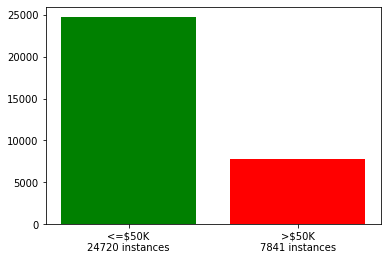

In [5]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [7]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [8]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [9]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

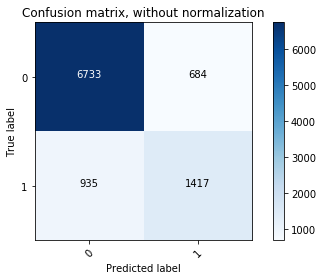

In [10]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***

**Task 1**: Please provide comments on the performance of the classifier.
Although an accuracy of 83% can be considered as good performance, but due to no information about the model parameters, it is difficult to evaluate a models performance, since there could be certain factors which come up with the volume and kind of data given to a model.
***

# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

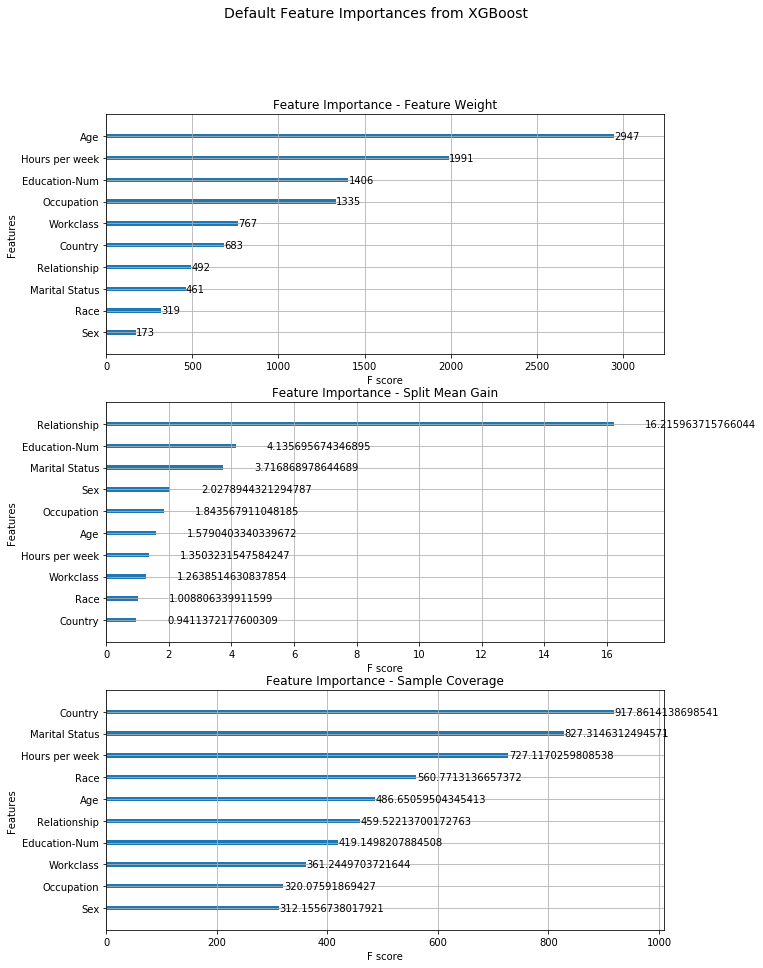

In [11]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.
The three rules for calculating the feature importance contradict each other, for example Age has the highest feature importance for the first rule, but that is not the case with the other two rules.
***

# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [12]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [13]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [33]:
# Change only the value of to select that person:
i = 1
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.21975029790778905
Prediction_local [0.06578546]
Right: 0.0003433658
********************
Test id:  1
Probability( <= $50K ) = 0.9996566
Probability( > $50K ) = 0.0003433658
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


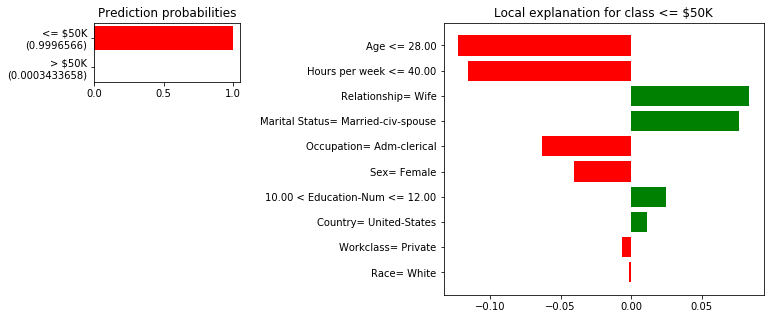

<Figure size 432x288 with 0 Axes>

In [34]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.
The explain_instance() function generates explanations for a prediction and makes it clear to understand the influence of each feature value to the result of prediction. As in the below tasks, the below tasks, the values of a feature can be used to determine the prediction result. It also can be usued for selecting the most important features from a dataset to train a model to avoid over-fitting. Here it is clear from the plot that Age and Hours-per-week are the important features.
***

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [36]:
instanceModified1 = X_test.iloc[1]
instanceModified1['Age'] = 50
instanceModified1['Hours per week'] = 42
print(instanceModified1)

Age               50.0
Workclass          4.0
Education-Num     11.0
Marital Status     2.0
Occupation         1.0
Relationship       5.0
Race               4.0
Sex                0.0
Hours per week    42.0
Country           39.0
Name: 26705, dtype: float32


Intercept 0.11709002501209162
Prediction_local [0.20067716]
Right: 0.0058001475


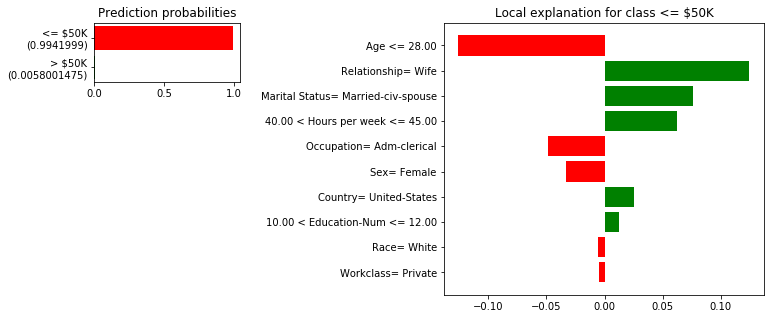

<Figure size 432x288 with 0 Axes>

In [26]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?

explain_instance() gives a clear explanation of what features contribute the most to the prediction, along with their range of values for which a perdiction holds true. For example, it is clear from the plot that Hours-per-week <=40, when a person's income <=50K



## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [37]:
# Change only the value of to select that person:
j = 0
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept 0.16385207400066434
Prediction_local [0.22409406]
Right: 0.53879607
********************
Test id:  0
Probability( <= $50K ) = 0.46120393
Probability( > $50K ) = 0.53879607
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


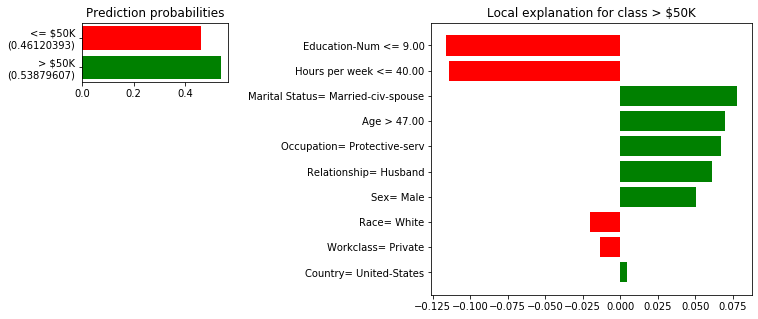

<Figure size 432x288 with 0 Axes>

In [28]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.
The explain_instance() function generates explanations for a prediction and makes it clear to understand the influence of each feature value to the result of prediction. As in the below tasks, the below tasks, the values of a feature can be used to determine the prediction result. It also can be usued for selecting the most important features from a dataset to train a model to avoid over-fitting. Here it is clear from the plot that Education-Num, Age, Occupation and Hours-per-week are the important features.
***

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [38]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Hours per week'] = 9
instanceModified2['Age'] = 27
print(instanceModified2)

Age               27.0
Workclass          4.0
Education-Num      9.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week     9.0
Country           39.0
Name: 5794, dtype: float32


Intercept 0.19606409354546495
Prediction_local [0.10618556]
Right: 0.00014112968


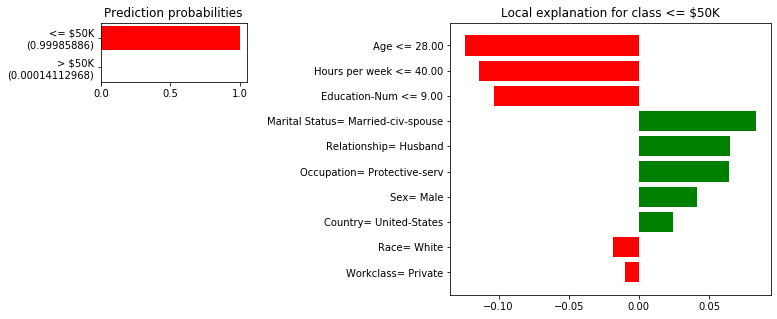

<Figure size 432x288 with 0 Axes>

In [39]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?

explain_instance() gives a clear explanation of what features contribute the most to the prediction, along with their range of values for which a perdiction holds true. For example, it is clear from the plot that Hours-per-week > 40, when a person's income is >50K



# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [72]:
# Change only the value of to select that person:
k = 4
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept -0.024909181105615796
Prediction_local [0.47418751]
Right: 0.7280066
********************
Test id:  4
Probability( <= $50K ) = 0.2719934
Probability( > $50K ) = 0.7280066
Predicted Label: 1
True class:  0
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


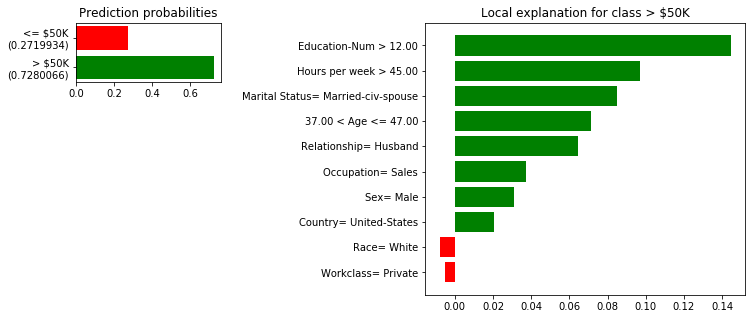

<Figure size 432x288 with 0 Axes>

In [69]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.
As it is shown in the explanation plot, most of the features(Education num, hours-per-week) present for this person fall into the class of people with an income of >50K, therefore, the model classifies it as >50K.

***

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [74]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Hours per week'] = 20
instanceModified3['Education-Num'] = 10
print(instanceModified3)

Age               42.0
Workclass          4.0
Education-Num     10.0
Marital Status     2.0
Occupation        12.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    20.0
Country           39.0
Name: 26674, dtype: float32


Intercept 0.0947517680653894
Prediction_local [0.27791505]
Right: 0.17687447


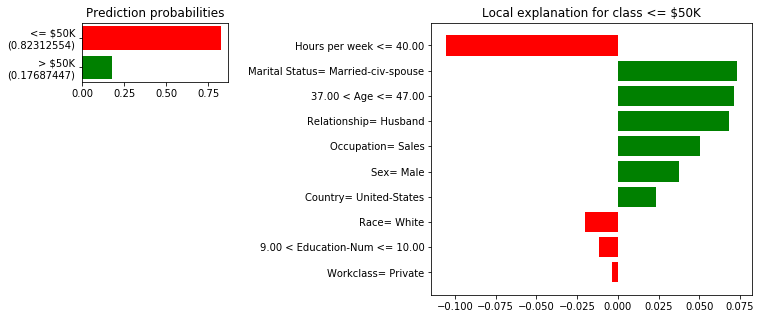

<Figure size 432x288 with 0 Axes>

In [75]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?
Education-num and Hours-per-week were the two important features responsible for incorrect prediction as shown in the explanation plot, changing the values of these two features corrected the error.





# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [76]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [77]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [78]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



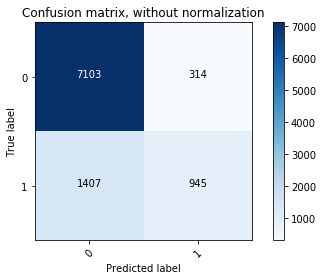

In [79]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***
**Task 15**:  Please provide comments on the performance of the decision Tree.
Since the decision tree is based on best first approach, the overall performance of the model drops a little.

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [82]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])


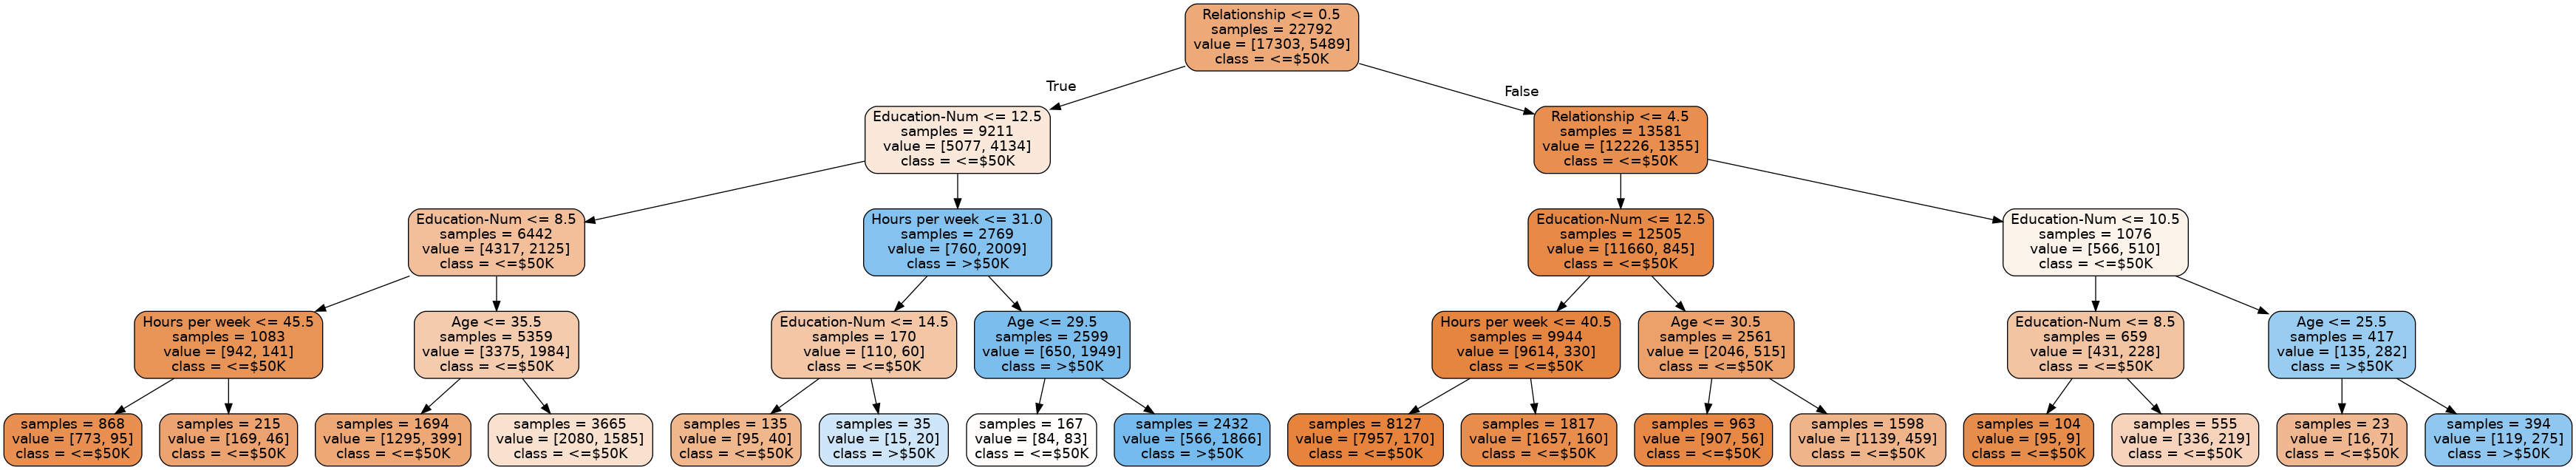

In [84]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 
The rules used to train the model have been represented by the tree, and can be derived from the tree structure.
For example: if Relationship <=0.5, Education-Num >=12.5, hours-per-week >= 31.0, Age >=29.5, then income is =>50K.

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [118]:
# Change only the value of to select that person:
h = 5
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.3239368452545732
Prediction_local [-0.05411794]
Right: 0.020917927894672082
********************
Test id:  5
Probability( <= $50K ) = 0.9790820721053279
Probability( > $50K ) = 0.020917927894672082
Predicted Label: 0
True class:  0
********************


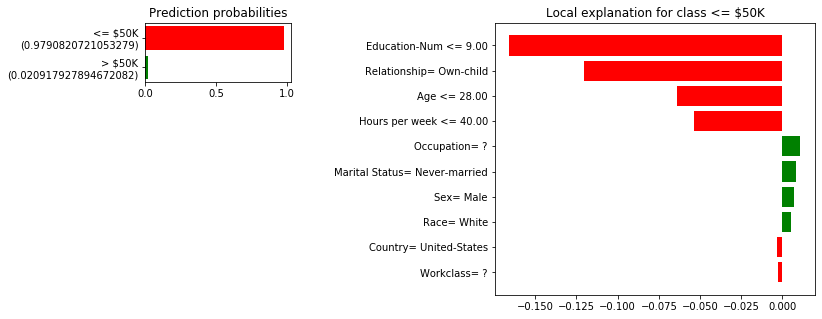

<Figure size 432x288 with 0 Axes>

In [119]:
plot_explanation(exp4, mapping)


In [90]:
instanceModified2 = X_test.iloc[0]

print(instanceModified2)

Age               51.0
Workclass          4.0
Education-Num      9.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    40.0
Country           39.0
Name: 5794, dtype: float32


***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.
The Relationship in this case >0.5 and <=4.5, Education-Num <= 12.5, Hours per week <=40.5, therefore it lands with an income of <=50K.

# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

Age               52.0
Workclass          4.0
Education-Num     13.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    47.0
Country           39.0
Name: 9770, dtype: float64
Intercept 0.021974597678677182
Prediction_local [0.58407724]
Right: 0.7672697368421053
********************
Test id:  5
Probability( <= $50K ) = 0.23273026315789475
Probability( > $50K ) = 0.7672697368421053
********************


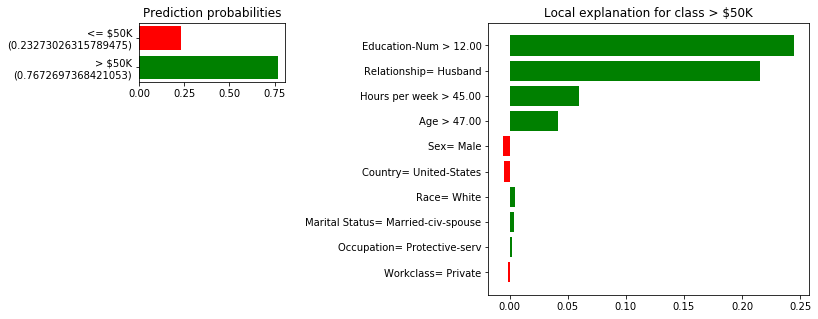

<Figure size 432x288 with 0 Axes>

In [122]:
#changing the last row for X_test
#the example has been created taking into consideration the criteria for income >50K,
#as seen from the above examples, Education-Num>9, Hours-per-week>40
example = [52, 4, 13, 2, 11, 0.0, 4, 1, 47, 39]
X_test.iloc[len(X_test)-1]=example
print(X_test.iloc[len(X_test)-1])
exp4 = explainer.explain_instance(X_test.iloc[len(X_test)-1].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[len(X_test)-1].values))
proba1 = tree.predict_proba(X_test.values)[len(X_test)-1]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print("********************")

plot_explanation(exp4, mapping)


# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

